# Question 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import statistics as stat
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor


pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

DIR_RAW = "../data/raw/"
DIR_CUR = "../data/curated/"
DIR_PLT = "../plots/"

df_suburb = pd.read_csv(f"{DIR_CUR}suburb_data.csv")
print(f"There are {df_suburb.shape[0]} suburbs")
display(df_suburb.head(3))

There are 211 suburbs


,suburb,count,weekly_rent,bond,num_beds,num_baths,num_parking,internal_area,land_area,other_sold_n_bed_suburb,neighbourhood_under_20,neighbourhood_20_to_39,neighbourhood_40_to_59,neighbourhood_above_60,neighbourhood_long_term_residents,neighbourhood_owners,neighbourhood_renter,neighbourhood_family,neighbourhood_single,performance_median_price,performance_auction_clearance,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_owner,demographic_renter,demographic_family,demographic_single,school_distance,park_distance,shop_distance,train_distance,stop_distance,population,median_weekly_income
0,abbotsford,52,548.600000,2387.020000,2.000000,1.365385,1.195122,NaN,NaN,79.120000,0.107692,0.555577,0.230577,0.104231,0.399231,0.347600,0.652400,0.505000,0.495000,762234.042553,0.514255,79.916667,72.510638,8443.680000,0.396000,0.604000,0.259200,0.740800,772.030769,434.905882,1081.582609,1406.405769,398.075000,9780.153846,1323.153846
1,abeckett street,19,501.842105,2470.909091,1.421053,1.105263,1.000000,NaN,NaN,455.736842,0.063158,0.776842,0.131579,0.033684,0.180714,0.260714,0.739286,0.285714,0.714286,443071.428571,0.436429,463.357143,127.357143,44828.428571,0.307143,0.692857,0.242143,0.757857,707.547368,493.621053,773.422222,388.752632,321.731579,17545.368421,675.105263
2,ada,25,455.416667,2034.720000,2.680000,1.800000,1.500000,NaN,NaN,135.750000,0.209565,0.466522,0.210870,0.107826,0.573000,0.550435,0.449565,0.528261,0.471739,727047.619048,0.534706,135.750000,71.761905,13646.280000,0.550000,0.450000,0.391200,0.608800,1815.372000,4185.372000,6630.104762,3456.820000,537.276000,12763.040000,781.040000


### Finding most important features in predicting Rent
Using the F-score we find the 3 features of the suburb data to have the strongest predictive power to the median rent.

In [2]:
df_clean = df_suburb.drop(["suburb", "bond", "internal_area", "land_area"], axis=1)
df_clean = df_clean.dropna().reset_index(drop=True)

K_BEST = 3

X = df_clean.drop(["weekly_rent"], axis=1)
y = df_clean["weekly_rent"]

selector = SelectKBest(f_regression, k=K_BEST)
selector.fit_transform(X, y)
features_index = selector.get_support(indices=True)
predictors = list(X.iloc[:, features_index].columns)

print("The most important features are:")
for predictor in predictors:
    print(f"* {predictor}")

The most important features are:
* performance_median_price
* school_distance
* median_weekly_income


### Distribution of most important features

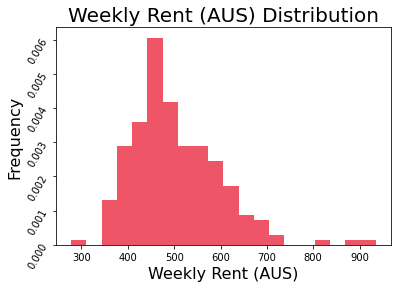

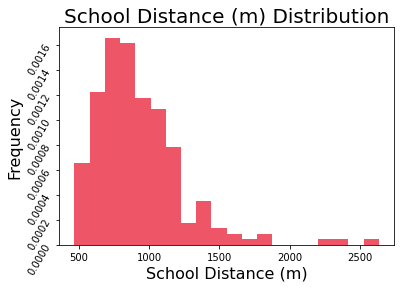

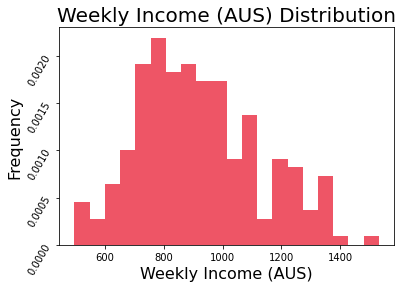

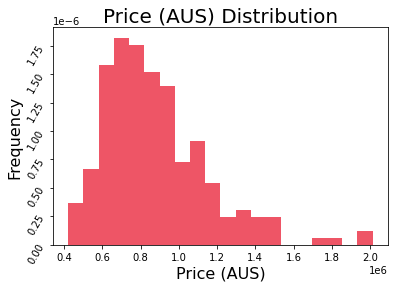

In [4]:
def distribution(x, bins, x_lab):
    """make histogram of x"""
    plt.hist(x, bins=bins, density=True, color="#ee5566")
    plt.title(f"{x_lab} Distribution", size=20)
    plt.xlabel(x_lab, size=16)
    plt.ylabel("Frequency", size=16)
    plt.yticks(rotation=60)
    plt.savefig(f"{DIR_PLT}{x_lab}.png")
    plt.show()
    
distribution(df_suburb["weekly_rent"], 20, "Weekly Rent (AUS)", )
distribution(df_suburb["school_distance"], 20, "School Distance (m)")
distribution(df_suburb["median_weekly_income"], 20, "Weekly Income (AUS)")
distribution(df_suburb["performance_median_price"], 20, "Price (AUS)")

### Plots of most important features VS the weekly rent

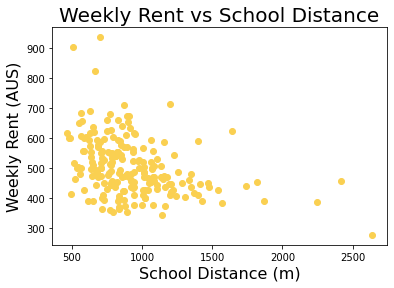

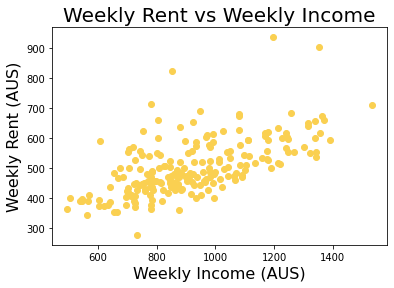

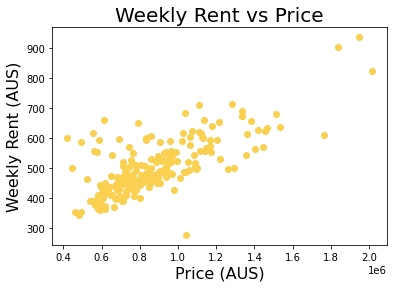

In [5]:
def vs(x, y, x_lab, y_lab, title, x_trans=lambda x: x, y_trans=lambda x: x):
    """creates a scatter plot between x and y"""
    plt.scatter(x_trans(x), y_trans(y), color="#fad051")
    plt.title(title, size=20)
    plt.xlabel(x_lab, size=16)
    plt.ylabel(y_lab, size=16)
    plt.show()


vs(df_suburb["school_distance"], df_suburb["weekly_rent"], "School Distance (m)",
   "Weekly Rent (AUS)", "Weekly Rent vs School Distance")
vs(df_suburb["median_weekly_income"], df_suburb["weekly_rent"], "Weekly Income (AUS)",
   "Weekly Rent (AUS)", "Weekly Rent vs Weekly Income")
vs(df_suburb["performance_median_price"], df_suburb["weekly_rent"],
   "Price (AUS)", "Weekly Rent (AUS)", "Weekly Rent vs Price")

### Modeling using the 3 most important features
A Linear Regression and Multi-Layer Perceptron Regressor are fitted between rent and the 3 best features identified above 

In [6]:
response = "weekly_rent"
scoring = "r2"

FOLDS = 8


def test_model(model, X, y):
    """Applys an 8-cross fold validation finding the R^2 for each fold"""
    scores = cross_val_score(model, X, y, scoring=scoring, cv=FOLDS)
    print(f"Min R^2:    {min(scores):.3f}")
    print(f"Max R^2:    {max(scores):.3f}")
    print(f"Median R^2: {stat.median(scores):.3f}")
    print(f"Mean R^2:   {stat.mean(scores):.3f}")


df_na_out = df_suburb.dropna(subset=predictors)

df_na_out = df_suburb.dropna(subset=predictors + [response]).reset_index(drop=True)

trans = ColumnTransformer(
    transformers=[("scale", StandardScaler(), predictors)])
X = trans.fit_transform(df_na_out[predictors])
y = df_na_out["weekly_rent"]

print("Linear Regression:")
test_model(LinearRegression(), X, y)

print("\nMulti-Layer Perceptron Regressor:")
test_model(MLPRegressor(random_state=30027,
           max_iter=1000000, n_iter_no_change=15), X, y)

Linear Regression:
Min R^2:    0.239
Max R^2:    0.789
Median R^2: 0.701
Mean R^2:   0.602

Multi-Layer Perceptron Regressor:
Min R^2:    -0.088
Max R^2:    0.727
Median R^2: 0.543
Mean R^2:   0.440


Looking at the median this has resulted in 2 reasonable models in predicting rent price. Meaning our 3 important features are good indicators of rent.